# Create ozone file
For single column with socrates, I want ozone in the upper troposphere for the absorption effect it provides. Here, I make the file containing the ozone mass mixing ratio (*kg/kg*).

I impose the same pressure distribution at each latitude.

## Create grid file
From previous single column simulation, create grid file containing lat, lon, pressure, time info

In [1]:
from isca_tools.run.create_files import create_grid_file, write_var
import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt

2025-04-10 09:13:29,156 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# job_dir = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/'
# Get name of previous experiment data file to use to create grid file
# This is just a single .nc data file within an output of a previous experiment
data_dir = os.environ['GFDL_DATA']
exp_prev = 'rossbypalooza/depth=20/all_nh/lat_10/column/base/'
month_use = 1
data_file_name = 'atmos_daily.nc'
exp_prev_data_file = os.path.join(data_dir, exp_prev, 'run%04d' % month_use, data_file_name)
ds = xr.open_dataset(exp_prev_data_file, use_cftime=True)    # sanity check that can load in data
ds

<xarray.Dataset> Size: 671kB
Dimensions:        (phalf: 26, time: 30, nv: 2, lon: 1, lonb: 2, lat: 64,
                    latb: 65, pfull: 25)
Coordinates:
  * phalf          (phalf) float64 208B 0.0 11.77 19.67 ... 977.8 989.7 1e+03
  * time           (time) object 240B 0001-01-01 12:00:00 ... 0001-01-30 12:0...
  * nv             (nv) float64 16B 1.0 2.0
  * lon            (lon) float64 8B 0.0
  * lonb           (lonb) float64 16B -180.0 180.0
  * lat            (lat) float64 512B -87.86 -85.1 -82.31 ... 82.31 85.1 87.86
  * latb           (latb) float64 520B -90.0 -86.58 -83.76 ... 83.76 86.58 90.0
  * pfull          (pfull) float64 200B 4.329 15.55 25.36 ... 970.2 983.8 994.9
Data variables: (12/20)
    pk             (phalf) float32 104B ...
    height         (time, pfull, lat, lon) float32 192kB ...
    temp           (time, pfull, lat, lon) float32 192kB ...
    ps             (time, lat, lon) float32 8kB ...
    sphum          (time, pfull, lat, lon) float32 192kB ...
    olr            (time, lat, lon) float32 8kB ...
    ...             ...
    cape           (time, lat, lon) float32 8kB ...
    cin            (time, lat, lon) float32 8kB ...
    average_T1     (time) object 240B ...
    average_T2     (time) object 240B ...
    average_DT     (time) timedelta64[ns] 240B ...
    time_bounds    (time, nv) timedelta64[ns] 480B ...
Attributes:
    filename:   atmos_daily.nc
    title:      FMS Model results
    grid_type:  regular
    grid_tile:  N/A

In [3]:
job_dir = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/'
exp_new = 'rossbypalooza/depth=20/all_nh/lat_10/column/socrates/'
grid_name = 'sc_grid.nc'
grid_file_path = os.path.join(job_dir, exp_new, grid_name)
if not os.path.exists(grid_file_path):
    create_grid_file(exp_prev_data_file, grid_file_path)
else:
    print(f'grid file already exists at \n{grid_file_path}')

grid file already exists at 
/Users/joshduffield/Documents/StAndrews/Isca/jobs/rossbypalooza/depth=20/all_nh/lat_10/column/socrates/sc_grid.nc


## Read in ozone from initial benchmark test
I want to create an ozone pressure distribution to provide to each latitude in the socrates single column simulation.
Here, I read in a previous ozone file from initial benchmarking simulation.

I impose the same ozone pressure distribution at each latitude.

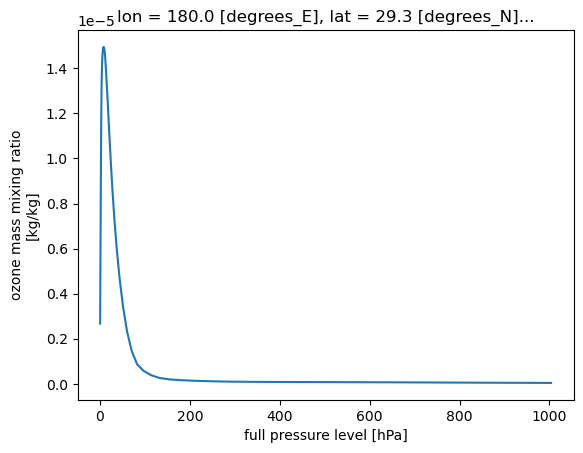

In [4]:
ozone_file_prev_exp = os.path.join(job_dir, 'benchmarking/experiments/socrates/ozone_1990.nc')
ozone_prev = xr.load_dataset(ozone_file_prev_exp, decode_times=False)
lat_ozone_use = 30      # choose 30 degrees as ozone peaks at equator and decreases with latitude, so choose somewhere in the middle
ozone_prev_use = ozone_prev.ozone_1990.isel(lon=0, time=0).sel(lat=30, method='nearest').load()     # just get lat=30 ozone and apply everywhere
ozone_prev_use.plot()
plt.show()

## Save ozone file for this experiment
Interpolate the above ozone data onto the grid file created for this single column simulation.

In [5]:
ozone_file_name = 'ozone.nc'
ozone_prev_save_array = ozone_prev_use.to_numpy().reshape(-1, 1, 1)      # reshape so n_pressure x n_lat=1 x n_lon=1
if not os.path.exists(os.path.join(job_dir, exp_new, ozone_file_name)):
    write_var(ozone_file_name, os.path.join(job_dir, exp_new), ozone_prev_save_array, lat_var=np.asarray([0]), lon_var=np.asarray([0]), time_var=None,
              pressure_var=ozone_prev_use.pfull.to_numpy(), lat_interpolate=True, lon_interpolate=True, time_interpolate=True, pressure_interpolate=True,
              grid_file=grid_file_path)
else:
    print(f'ozone file already exists at \n{os.path.join(job_dir, exp_new, ozone_file_name)}')

ozone file already exists at 
/Users/joshduffield/Documents/StAndrews/Isca/jobs/rossbypalooza/depth=20/all_nh/lat_10/column/socrates/ozone.nc


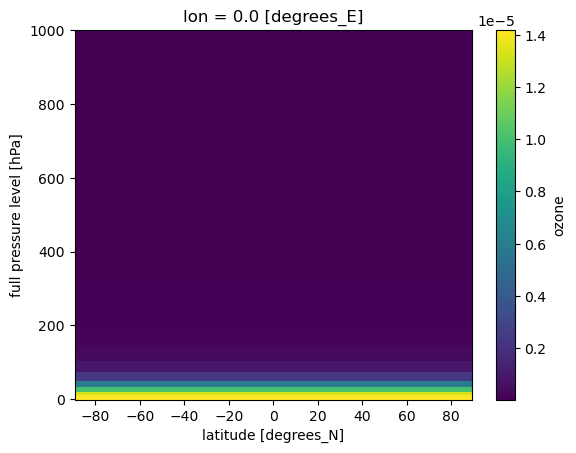

In [6]:
# Load in ozone data as sanity check that matches expectation i.e. peaked at top of atmosphere
ozone_load_in = xr.load_dataset(os.path.join(job_dir, exp_new, ozone_file_name), decode_times=False)
ozone_load_in.ozone.isel(lon=0).plot()
plt.show()